# Multivariate Multistep CNN Example

Based on:
* [Time Series Forecasting on Stock Prices](https://www.youtube.com/watch?v=j05UUs99eNQ) from [Coding Tech](https://www.youtube.com/channel/UCtxCXg-UvSnTKPOzLH4wJaQ)
* https://machinelearningmastery.com/how-to-develop-convolutional-neural-network-models-for-time-series-forecasting/

**Disclaimer:** _Investing in the stock market involves risk and can lead to monetary loss. This material is purely for educational purposes and should not be taken as professional investment advice. Invest at your own discretion._

Import the libraries

In [1]:
import pandas as pd
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

import matplotlib.pyplot as plt

Load the data

In [2]:
df = pd.read_csv("SP500.csv")

Show the data

In [3]:
df

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2000-05-19,96.106028,96.106028,94.484962,94.779701,775500,0.0,0
1,2000-05-22,94.716551,94.716551,92.169162,94.190231,1850600,0.0,0
2,2000-05-23,94.463952,94.463952,92.758675,92.758675,373900,0.0,0
3,2000-05-24,92.800753,94.358660,92.063905,94.148132,400300,0.0,0
4,2000-05-25,94.337613,94.948145,92.884970,93.284973,69600,0.0,0
...,...,...,...,...,...,...,...,...
5359,2021-09-08,452.899994,453.679993,450.869995,453.000000,4076800,0.0,0
5360,2021-09-09,452.690002,454.579987,450.730011,450.980011,3851600,0.0,0
5361,2021-09-10,453.059998,453.510010,447.299988,447.540009,3023500,0.0,0
5362,2021-09-13,450.679993,450.929993,446.089996,448.579987,3007400,0.0,0


Add indices for every day in the period

In [4]:
start_date = df.Date.min()
end_date = df.Date.max()

In [5]:
df_date = pd.date_range(start=start_date, end=end_date).to_frame(name="Date")
df_date.reset_index(drop=True, inplace=True) 

In [6]:
df["Date"] = pd.to_datetime(df["Date"])
df = df.merge(df_date, how='right')

Interpolate missing values

In [7]:
df = df.interpolate(method='linear', limit_direction='both')

Remove not needed columns

In [8]:
df = df[['Date', 'Close']].copy()

In [9]:
df

,Date,Close
0,2000-05-19,94.779701
1,2000-05-20,94.583211
2,2000-05-21,94.386721
3,2000-05-22,94.190231
4,2000-05-23,92.758675
...,...,...
7784,2021-09-10,447.540009
7785,2021-09-11,447.886668
7786,2021-09-12,448.233327
7787,2021-09-13,448.579987


**Simple Moving Average**
* Example periods: 15, 30 or 45 days

In [10]:
def computeSMA(data, period, column='Close'):
    return data[column].rolling(window=period).mean()

In [11]:
df['SMA'] = computeSMA(df, period=15)

**Exponential Moving Averages**
* Example periods: 15, 30 or 45 days

In [12]:
def computeEMA(data, period, column='Close'):
    return data[column].ewm(span=period, adjust=False).mean()

In [13]:
df['EMA'] = computeEMA(df, period=15)

**Relative Strength Index**

In [14]:
def computeRSI(data, period=14, column='Close'):
    delta = data[column].diff(1)
    delta = delta.dropna()
    up = delta.copy()
    down = delta.copy()
    up[up < 0] = 0
    down[down > 0] = 0
    data['up'] = up
    data['down'] = down
    AVG_Gain = computeSMA(data, period, column='up')
    AVG_Loss = abs(computeSMA(data, period, column='down'))
    RS = AVG_Gain / AVG_Loss
    RSI = 100.0 - (100.0 / (1.0 + RS))
    return RSI

In [15]:
df['RSI'] = computeRSI(df, period=14)

**Moving Average Convergence Divergence**

In [16]:
def MACD(data, period1=26, period2=12, signal=9, column='Close'):
    exp1 = computeEMA(data,period1, column=column)
    exp2 = computeEMA(data,period2, column=column)
    data['MACD'] = exp2 - exp1
    data['Signal Line'] = computeSMA(data, signal, column='MACD')

In [17]:
MACD(df)

Remove NaNs

In [18]:
df = df.dropna()

In [19]:
df

,Date,Close,SMA,EMA,up,down,RSI,MACD,Signal Line
14,2000-06-02,99.663971,94.910938,95.600925,1.936874,0.000000,71.245582,0.680463,-0.042866
15,2000-06-03,99.446431,95.222053,96.081613,0.000000,-0.217539,71.115354,0.916439,0.090681
16,2000-06-04,99.228892,95.531765,96.475023,0.000000,-0.217539,70.985601,1.073524,0.250695
17,2000-06-05,99.011353,95.840074,96.792064,0.000000,-0.217539,70.856321,1.167008,0.420929
18,2000-06-06,98.506065,96.127796,97.006314,0.000000,-0.505287,77.029581,1.186644,0.585988
...,...,...,...,...,...,...,...,...,...
7784,2021-09-10,447.540009,453.257671,451.878931,0.000000,-3.440002,30.279938,1.487905,2.619024
7785,2021-09-11,447.886668,452.970782,451.379898,0.346659,0.000000,28.313930,1.046934,2.394046
7786,2021-09-12,448.233327,452.662337,450.986577,0.346659,0.000000,26.233827,0.717167,2.129901
7787,2021-09-13,448.579987,452.332335,450.685753,0.346659,0.000000,24.029401,0.478284,1.844411


Separate a multivariate sequence into samples

In [20]:
def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        # Find the end of the pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # Check if we are bound by sequence
        if out_end_ix > len(sequences) - 1:
            break
        # Gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    
    return np.array(X), np.array(y)

Define input sequence

In [21]:
in_seq1 = df['SMA'].values
in_seq2 = df['EMA'].values
in_seq3 = df['RSI'].values
in_seq4 = df['MACD'].values
in_seq5 = df['Signal Line'].values
out_seq = df['Close'].values

Convert to [rows, columns] structure

In [22]:
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
in_seq3 = in_seq3.reshape((len(in_seq3), 1))
in_seq4 = in_seq4.reshape((len(in_seq4), 1))
in_seq5 = in_seq5.reshape((len(in_seq5), 1))
out_seq = out_seq.reshape((len(out_seq), 1))

Horizontally stack columns

In [23]:
dataset = np.hstack((in_seq1, in_seq2, in_seq3, in_seq4, in_seq5, out_seq))

Choose a number of time steps

In [24]:
n_steps_in = 10
n_steps_out = 3

Convert into input/output

In [25]:
X, y = split_sequences(dataset, n_steps_in, n_steps_out)

Flatten output

In [26]:
n_output = y.shape[1] * y.shape[2]
y = y.reshape((y.shape[0], n_output))

The dataset knows the number of the features, e.g. 2

In [27]:
n_features = X.shape[2]

Set test data

In [28]:
test_size = n_steps_in
prediction_size = n_features
y_test = y[-test_size-prediction_size:-prediction_size]
X_test = X[-test_size-prediction_size:-prediction_size]

In [29]:
y_expected = y[-prediction_size:]

In [30]:
y = y[:-test_size-prediction_size]
X = X[:-test_size-prediction_size]

Define model

In [31]:
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps_in, n_features)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(n_output))

In [32]:
model.compile(optimizer='adam', loss='mse')

Fit model

In [33]:
model.fit(X, y, epochs=100)

Epoch 1/100
243/243 [==============================] - 0s 818us/step - loss: 643.8380
Epoch 2/100
243/243 [==============================] - 0s 699us/step - loss: 39.7718
Epoch 3/100
243/243 [==============================] - 0s 678us/step - loss: 35.7966
Epoch 4/100
243/243 [==============================] - 0s 711us/step - loss: 34.9110
Epoch 5/100
243/243 [==============================] - 0s 675us/step - loss: 34.3067
Epoch 6/100
243/243 [==============================] - 0s 681us/step - loss: 33.9526
Epoch 7/100
243/243 [==============================] - 0s 684us/step - loss: 33.2908
Epoch 8/100
243/243 [==============================] - 0s 677us/step - loss: 33.6401
Epoch 9/100
243/243 [==============================] - 0s 668us/step - loss: 32.3106
Epoch 10/100
243/243 [==============================] - 0s 667us/step - loss: 32.9535
Epoch 11/100
243/243 [==============================] - 0s 668us/step - loss: 31.8015
Epoch 12/100
243/243 [==============================] - 0s 679

243/243 [==============================] - 0s 709us/step - loss: 23.5638
Epoch 97/100
243/243 [==============================] - 0s 682us/step - loss: 24.2567
Epoch 98/100
243/243 [==============================] - 0s 665us/step - loss: 23.1619
Epoch 99/100
243/243 [==============================] - 0s 694us/step - loss: 23.4990
Epoch 100/100
243/243 [==============================] - 0s 714us/step - loss: 24.0373


Demonstrate training

In [34]:
yhat = model.predict(X)

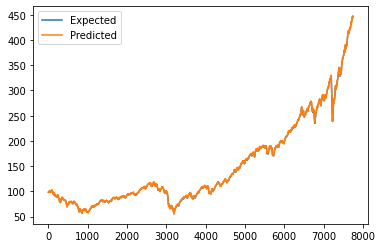

In [35]:
plt.plot(y[:,0], label='Expected')
plt.plot(yhat[:,0], label='Predicted')
plt.legend()
plt.show()

Demonstrate prediction

In [36]:
yhat = model.predict(X_test)
yhat = yhat.reshape((yhat.shape[0], n_steps_out, n_features))
y_test = y_test.reshape((y_test.shape[0], n_steps_out, n_features))

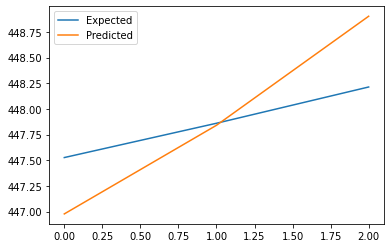

In [37]:
plt.plot(y_test[0,:,0], label='Expected')
plt.plot(yhat[0,:,0], label='Predicted')
plt.legend()
plt.show()

**THIS IS NOT AN INVESTMENT ADVICE!**